Antall manglende verdier FØR opprydning:
År                               0
Uke                              0
Fersk laks - Kilospris        1122
Fersk laks - Vekt (tonn)      1125
Frosset laks - Kilospris      1129
Frosset laks - Vekt (tonn)    1123
UkeDato                          0
dtype: int64

Antall manglende verdier ETTER opprydning:
År                            0
Uke                           0
Fersk laks - Kilospris        0
Fersk laks - Vekt (tonn)      0
Frosset laks - Kilospris      0
Frosset laks - Vekt (tonn)    0
UkeDato                       0
dtype: int64
Antall manglende verdier (bare NaN):
År                               0
Uke                              0
Fersk laks - Kilospris        1122
Fersk laks - Vekt (tonn)      1125
Frosset laks - Kilospris      1129
Frosset laks - Vekt (tonn)    1123
UkeDato                          0
dtype: int64
Antall rader etter fjerning: 1323


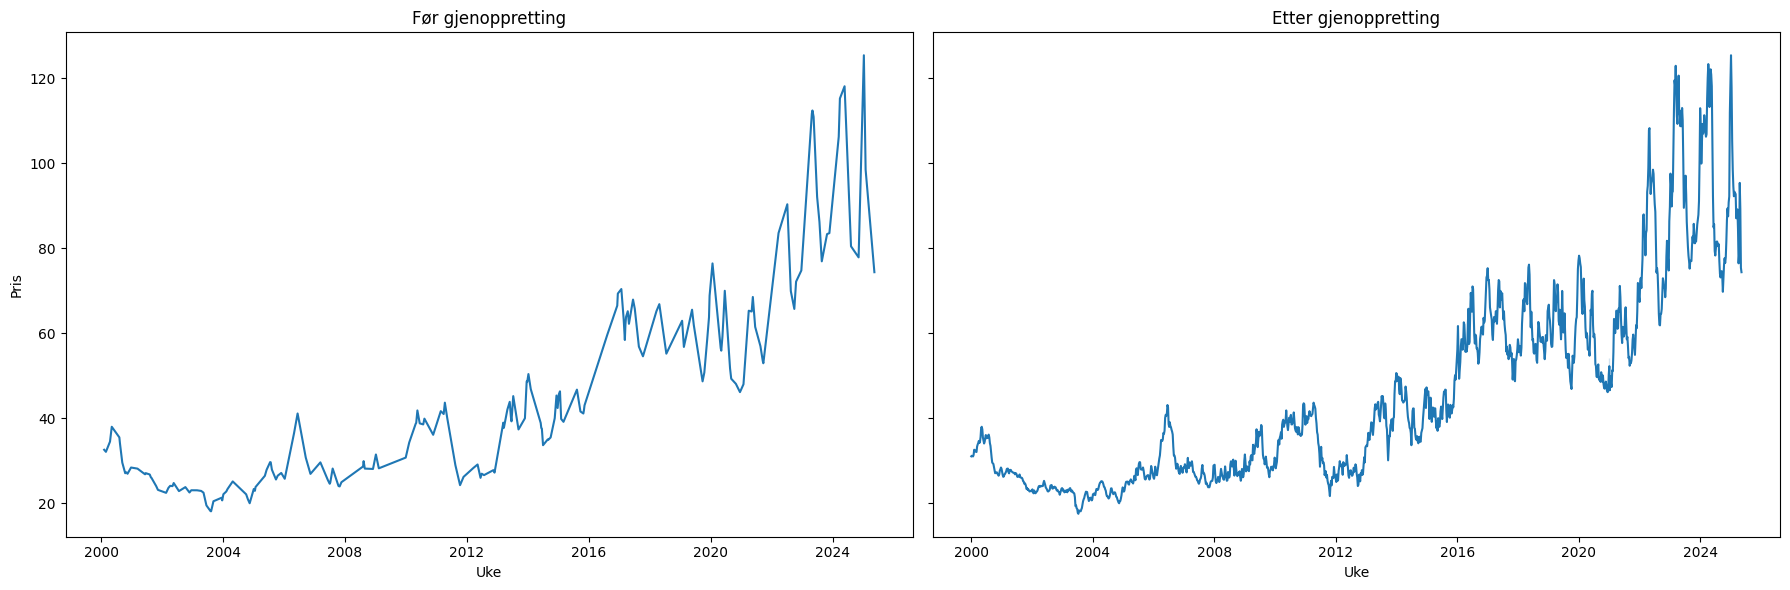

In [121]:
##den originale koden som jeg skal legge til nullverdier og manipulere 

import requests
import pandas as pd
from itertools import product

# URL til SSB API for tabell 03024
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    """Henter data fra SSB API og returnerer JSON-responsen."""
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}\n{response.text}")

def process_data(data):
    """Prosesserer JSON-data og returnerer en formatert Pandas DataFrame."""
    dimension_names = list(data["dimension"].keys())
    values = data["value"]

    # Kombinasjoner av dimensjoner
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))

    # Lag DataFrame og knytt til verdiene
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values

    # Pivotér data
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["Tid", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]




    # Del opp "Tid" i År og Uke
    df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int)
    df_pivot["Uke"] = df_pivot["Tid"].str[5:].astype(int)
   


    # Fjern "Tid" og omorganiser kolonner slik at År og Uke kommer først
    df_pivot = df_pivot.drop(columns=["Tid"])
    kolonnerekkefølge = ["År", "Uke"] + [col for col in df_pivot.columns if col not in ["År", "Uke"]]
    df_pivot = df_pivot[kolonnerekkefølge]

    # Lag en uke-dato-kolonne for plotting (mandag i hver uke)
    df_pivot["UkeDato"] = pd.to_datetime(df_pivot["År"].astype(str) + "-" + df_pivot["Uke"].astype(str).str.zfill(2) + "-1", format="%Y-%W-%w")


    return df_pivot


df_original = df_pivot.copy(deep=True)

##---------------------------- hoveddel -----------------------------##

data = fetch_data()
df_pivot = process_data(data)
df_original = df_pivot.copy(deep=True)



#Sett NaN mange tilfedlige kolonner i datasettet 
for i in range(10000):
    row_idx = random.randint(0, len(df_pivot) - 1)
    col = random.choice([
        "Fersk laks - Kilospris", 
        "Fersk laks - Vekt (tonn)", 
        "Frosset laks - Kilospris", 
        "Frosset laks - Vekt (tonn)"
    ])
    df_pivot.at[row_idx, col] = float("nan")

# Lag en kopi med skadede verdier (men samme rader som original)
df_pivot_damaged = df_pivot.copy()



#mer spesifikt og fjerner tilfeldige NaN i "Fersk laks - Kilospris" kolonnen
for i in range(2000):
    row_idx = random.randint(0, len(df_pivot) - 1)
    df_pivot.at[row_idx, "Fersk laks - Kilospris"] = float("nan")




#printer ut antall null-verdier i hver kolonne 
print("Antall manglende verdier FØR opprydning:")
print(df_pivot_damaged.isnull().sum())


#printer ut antall null-verdier etter opprydning 
df_renset = df_pivot_damaged.dropna()
print("\nAntall manglende verdier ETTER opprydning:")
print(df_renset.isnull().sum())



print("Antall manglende verdier (bare NaN):")
print(df_pivot_damaged.isnull().sum())

#her oppserverer vi at antall manglende verdier går ned til 0.


print("Antall rader etter fjerning:", len(df_pivot_damaged))


df_opprettet = df_pivot_damaged.copy()
for col in df_opprettet.columns:
    df_opprettet[col] = df_opprettet[col].fillna(df_original[col])



#åplotter to figurer som viser forskjellen, for visualisering 
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.lineplot(data=df_pivot_damaged, x="UkeDato", y="Fersk laks - Kilospris", ax=axs[0])
axs[0].set_title("Før gjenoppretting")
axs[0].set_xlabel("Uke")
axs[0].set_ylabel("Pris")

sns.lineplot(data=df_opprettet, x="UkeDato", y="Fersk laks - Kilospris", ax=axs[1])
axs[1].set_title("Etter gjenoppretting")
axs[1].set_xlabel("Uke")

plt.tight_layout()
plt.show()


